In [68]:
from sklearn.datasets import make_circles
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import SpectralClustering, KMeans

# create the data
X, y = make_circles(n_samples=500, noise=0.05, factor=.5)

# use the nearest neighbor graph as our adjacency matrix
A = kneighbors_graph(X, n_neighbors=5).toarray()
print(A)
 
# create the graph laplacian
D = np.diag(A.sum(axis=1))
L = D-A

# find the eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# use Fiedler value to find best cut to separate data
clusters = vecs[:,1] > 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


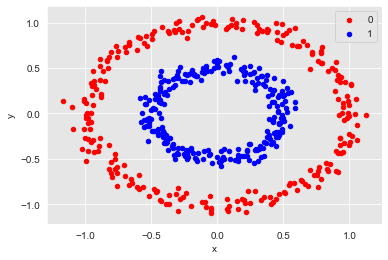

In [69]:
# # generate 2d classification dataset
# X, y = make_circles(n_samples=500, noise=0.1,factor=0.2)
# # scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

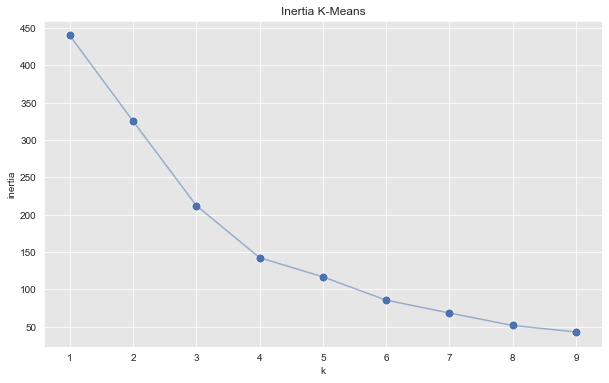

In [74]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

inertias = []

k_candidates = range(1, 10)

for k in k_candidates:
    k_means = KMeans(random_state=0, n_clusters=k)
    k_means.fit(df)
    inertias.append(k_means.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
# sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

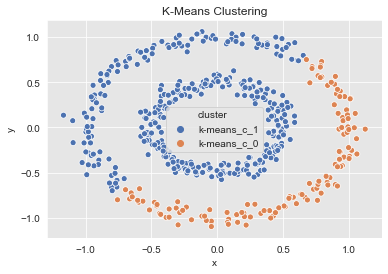

In [71]:
# k_means = KMeans(random_state=25, n_clusters=2)
# k_means.fit(df)
# cluster = k_means.predict(df)

# cluster = ['k-means_c_' + str(c) for c in cluster]

# fig, ax = plt.subplots()
# sns.scatterplot(x='x', y='y', data=df.assign(cluster = cluster), hue='cluster', ax=ax)
# ax.set(title='K-Means Clustering');

/Users/yashsjoshi/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


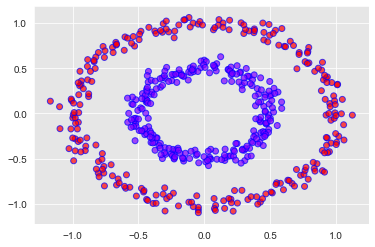

In [72]:
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(df)
plt.scatter(X[:,0], X[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

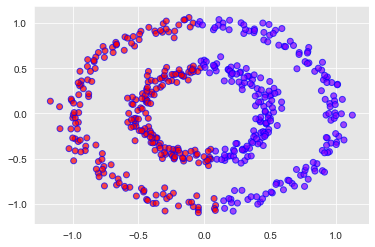

In [73]:
km = KMeans(init='k-means++', n_clusters=2)
km_clustering = km.fit(df)
plt.scatter(X[:,0], X[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

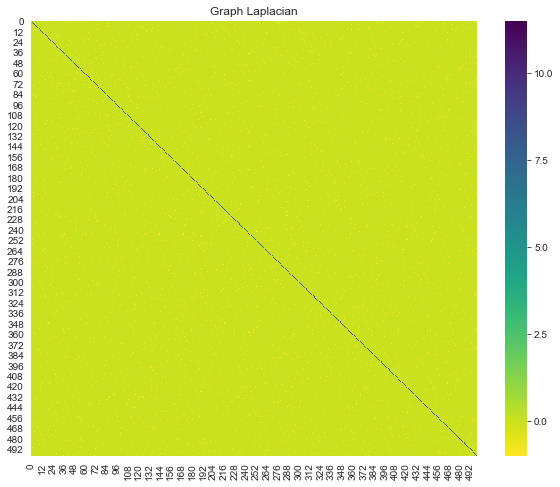

In [76]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=df, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

In [79]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [80]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [81]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999998
Max Norm: 1.0000000000000002


In [82]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

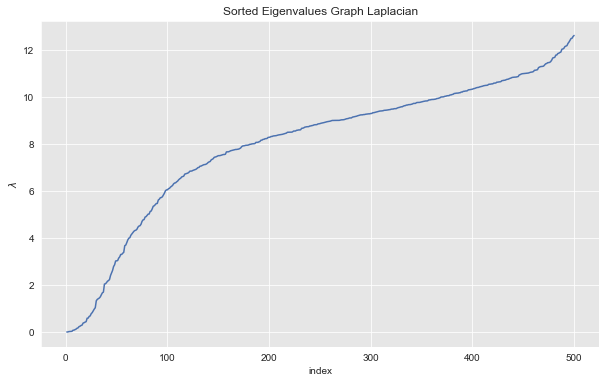

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

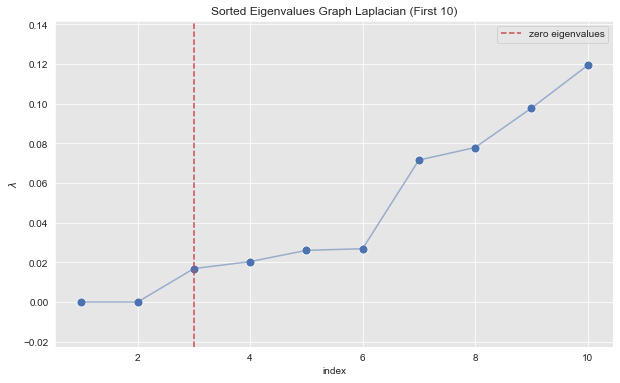

In [84]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [85]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[ 2.19260800e-16],
       [-6.36967232e-15]])

In [86]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0,v_1
0,-0.063245,0.000537
1,-0.000317,-0.063243
2,-0.063245,0.000537
3,-0.063245,0.000537
4,-0.063245,0.000537


In [88]:
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)


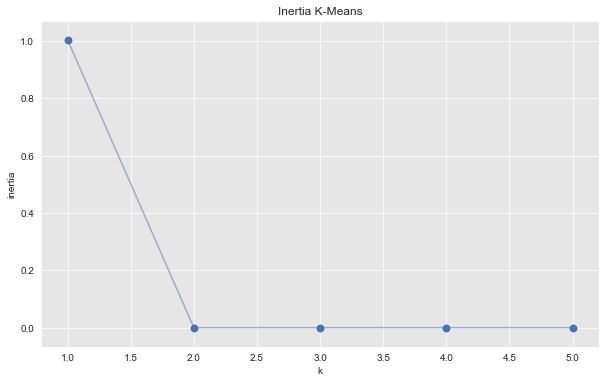

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

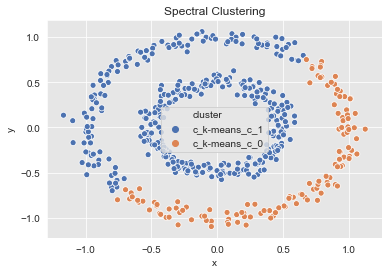

In [92]:
df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');